# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Luis Adrian Bravo Ramirez

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://4f3c6067fdf1:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 13:51:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!pwd

/opt/spark/work-dir


# Creating Agencies Dataframe

In [3]:
from pyspark.sql.functions import get_json_object 
from luisbravor00.spark_utils import SparkUtils

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")
df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, '$.agency_name'))

# Creating Brands Dataframe

In [4]:
schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")

# Creating Cars Dataframe

In [5]:
schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")
df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.car_info, '$.car_name'))

# Creating Customers Dataframe

In [6]:
schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")
df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customer_info, '$.customer_name'))

# Creating Rentals Dataframe

In [7]:
schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")
df_rentals = df_rentals \
    .withColumn("car_id", get_json_object(df_rentals.rental_info, '$.car_id')) \
    .withColumn("customer_id", get_json_object(df_rentals.rental_info, '$.customer_id')) \
    .withColumn("agency_id", get_json_object(df_rentals.rental_info, '$.agency_id'))

# Obtaining final Dataframe


In [8]:
# Join all the dataframes
df_final = df_rentals \
    .join(df_cars, on='car_id', how='left') \
    .join(df_agencies, on='agency_id', how='left') \
    .join(df_customers, on='customer_id', how='left') \

# Filter out the values (not needed)

# Select the required columns
df_final = df_final.select("rental_id", "car_name", "agency_name", "customer_name")

df_final.show(truncate=False)

+---------+-----------------------------------+-------------+---------------+
|rental_id|car_name                           |agency_name  |customer_name  |
+---------+-----------------------------------+-------------+---------------+
|11891    |Wallace-Carlson Model 9            |NYC Rentals  |Margaret Jones |
|11892    |Grimes-Green Model 8               |LA Car Rental|Albert Williams|
|11893    |Stewart-Allen Model 5              |SF Cars      |Caleb Fleming  |
|11894    |Campos PLC Model 4                 |NYC Rentals  |Andrew Butler  |
|11895    |Wagner LLC Model 1                 |SF Cars      |Kristin Potts  |
|11896    |Jones, Jefferson and Rivera Model 7|LA Car Rental|Jeremy Parks   |
|11897    |Lopez and Sons Model 9             |Zapopan Auto |Terry Wells    |
|11898    |Salazar Ltd Model 8                |SF Cars      |Marc Williams  |
|11899    |Villanueva PLC Model 7             |LA Car Rental|Danny Williams |
|11900    |Faulkner-Howard Model 5            |SF Cars      |Eri

# Persist Data


## Parquet File

In [9]:
!pwd
!ls -l
!du -sh data/car_service/rentals

/opt/spark/work-dir
total 0
drwxr-xr-x  3 root root   96 Sep 26 13:51 artifacts
drwxr-xr-x  8 root root  256 Sep 23 14:19 data
drwxr-xr-x 32 root root 1024 Sep 26 13:21 examples
drwxr-xr-x  3 root root   96 Sep  5 23:55 img
drwxr-xr-x  6 root root  192 Sep 23 22:40 labs
drwxr-xr-x 27 root root  864 Sep 23 13:46 lib
1.1M	data/car_service/rentals


In [11]:
base_path = "/opt/spark/work-dir/data/"
df_final.write \
    .mode("overwrite") \
    .parquet(base_path + "car_service/output/parquet")    

In [13]:
!ls -l data/car_service/output/parquet/
!du -sh data/car_service/output/parquet/

total 116
-rw-r--r-- 1 root root 59288 Sep 26 13:53 part-00000-f43a408b-9464-42c6-81a5-27cff39a4eb3-c000.snappy.parquet
-rw-r--r-- 1 root root 54315 Sep 26 13:53 part-00001-f43a408b-9464-42c6-81a5-27cff39a4eb3-c000.snappy.parquet
-rw-r--r-- 1 root root     0 Sep 26 13:53 _SUCCESS


128K	data/car_service/output/parquet/


In [14]:
df_final.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .parquet(base_path + "car_service/output/parquet")   

In [15]:
!ls -l data/car_service/output/parquet/
!du -sh data/car_service/output/parquet/

total 0
drwxr-xr-x 6 root root 192 Sep 26 14:01 'agency_name=LA Car Rental'
drwxr-xr-x 6 root root 192 Sep 26 14:01 'agency_name=NYC Rentals'
drwxr-xr-x 6 root root 192 Sep 26 14:01 'agency_name=SF Cars'
drwxr-xr-x 6 root root 192 Sep 26 14:01 'agency_name=Zapopan Auto'
-rw-r--r-- 1 root root   0 Sep 26 14:01  _SUCCESS
180K	data/car_service/output/parquet/


## Create a CSV File

In [28]:
df_final.write \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

In [30]:
!ls -l data/car_service/output/csv/
!du -sh data/car_service/output/csv/


total 1016
-rw-r--r-- 1 root root 548049 Sep 26 14:11 part-00000-6b2a5e91-b539-4c9c-8ef4-d75ec5b661ac-c000.csv
-rw-r--r-- 1 root root 489141 Sep 26 14:11 part-00001-6b2a5e91-b539-4c9c-8ef4-d75ec5b661ac-c000.csv
-rw-r--r-- 1 root root      0 Sep 26 14:11 _SUCCESS


1.1M	data/car_service/output/csv/


25/09/26 15:00:58 ERROR TaskSchedulerImpl: Lost executor 0 on 172.18.0.3: worker lost: Not receiving heartbeat for 60 seconds


In [31]:
sc.stop()

# PowerBI Dashboard

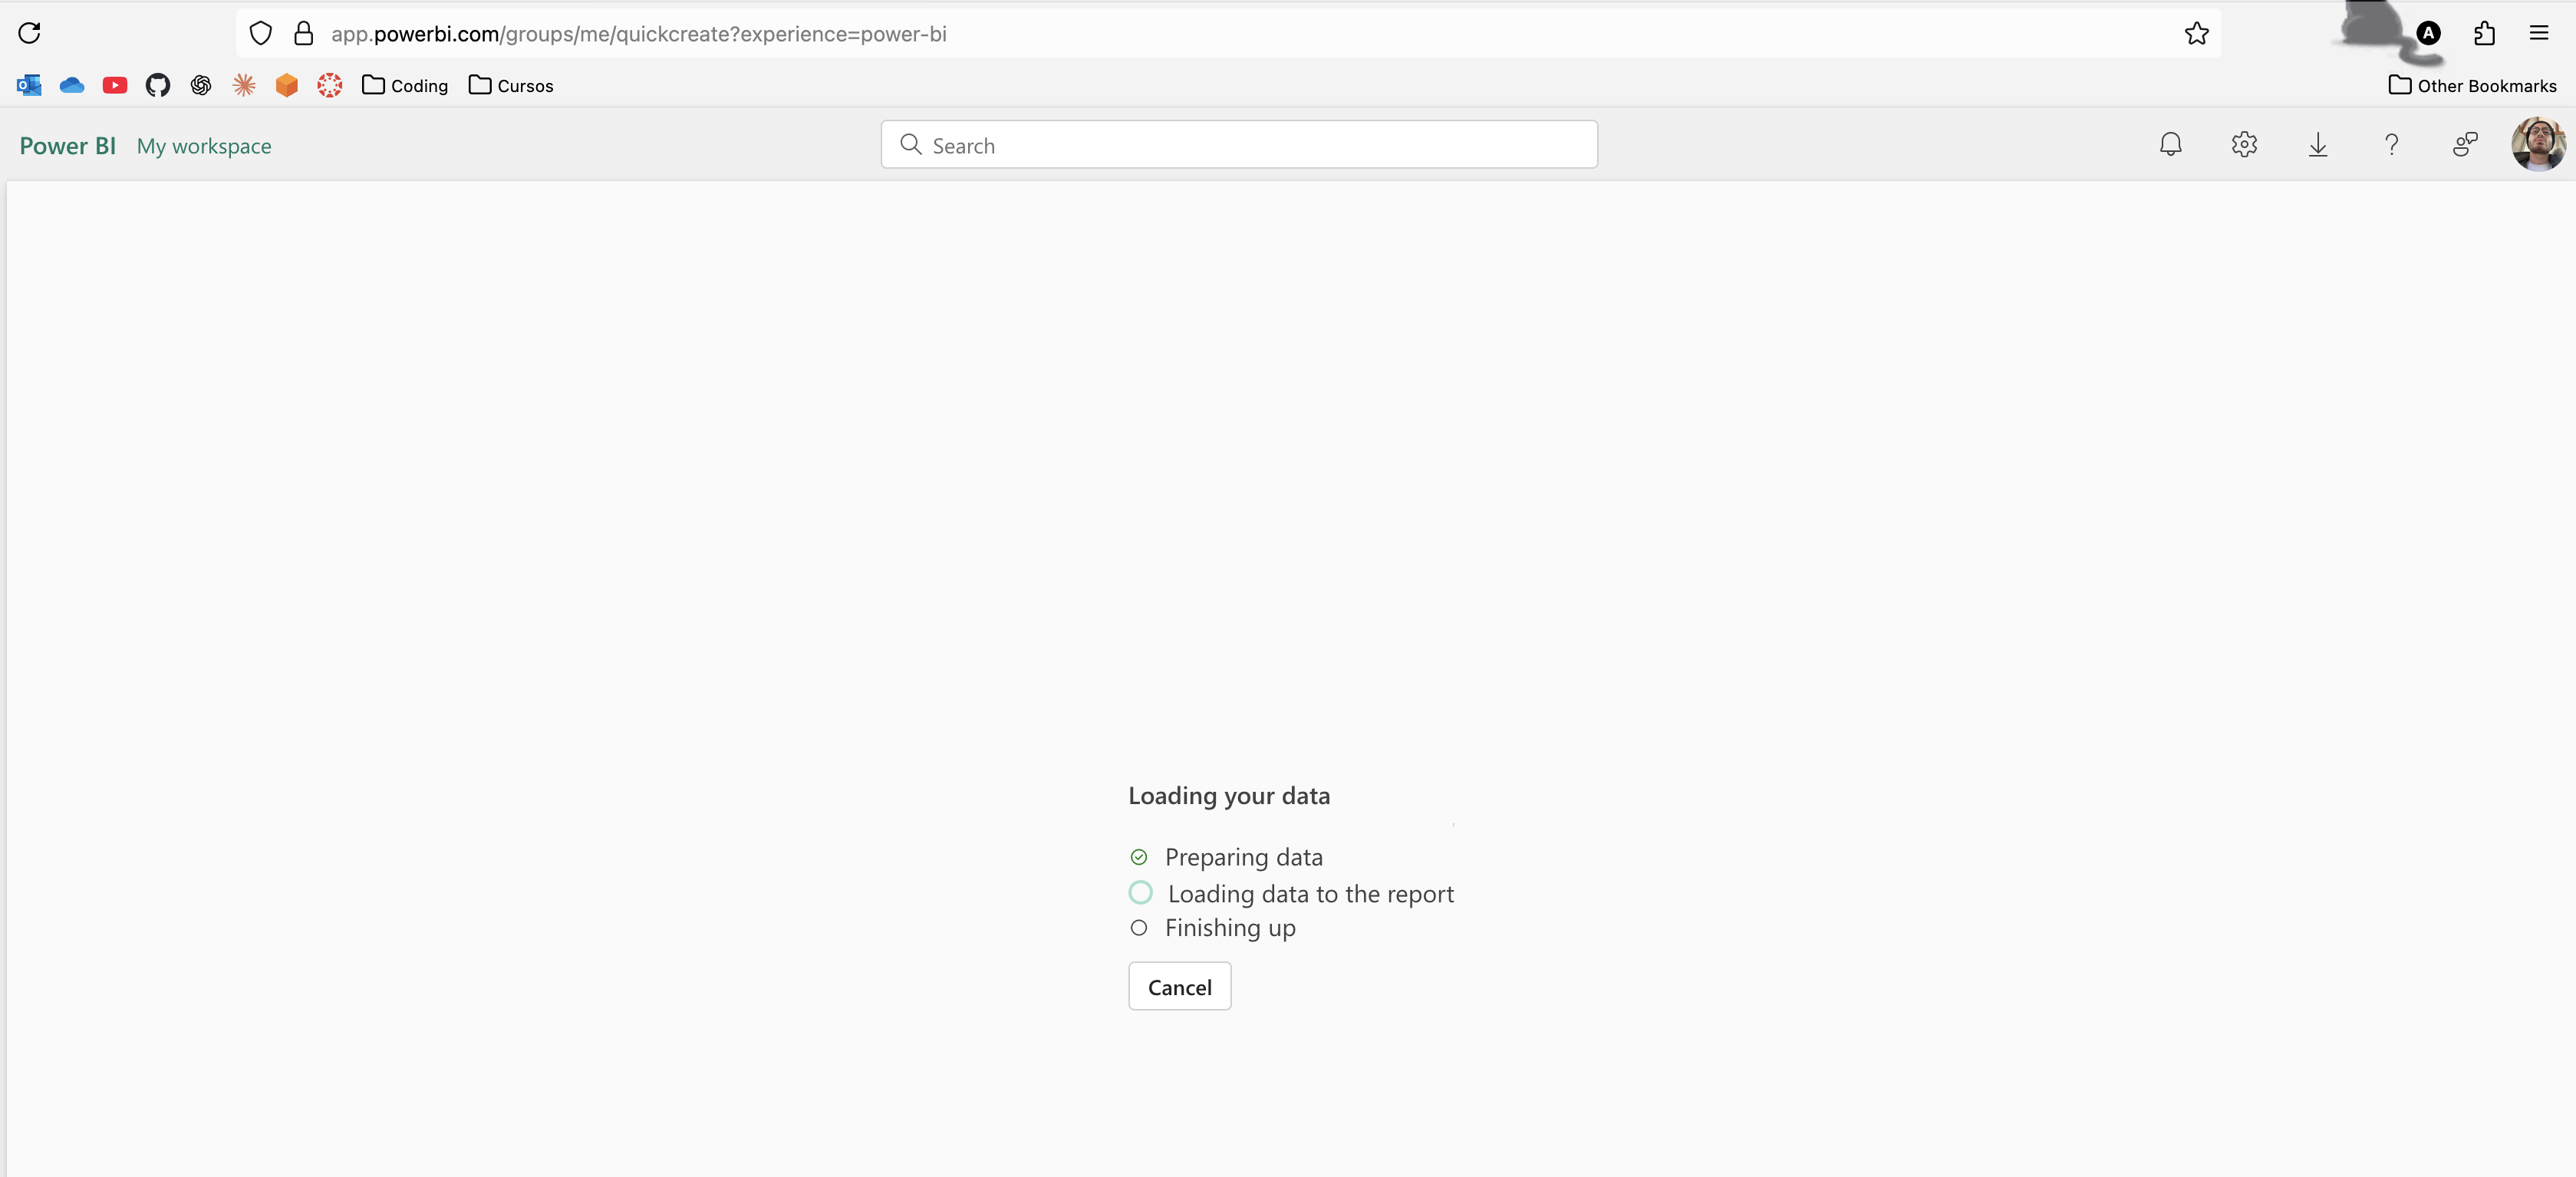

## Cars by Customers (General)

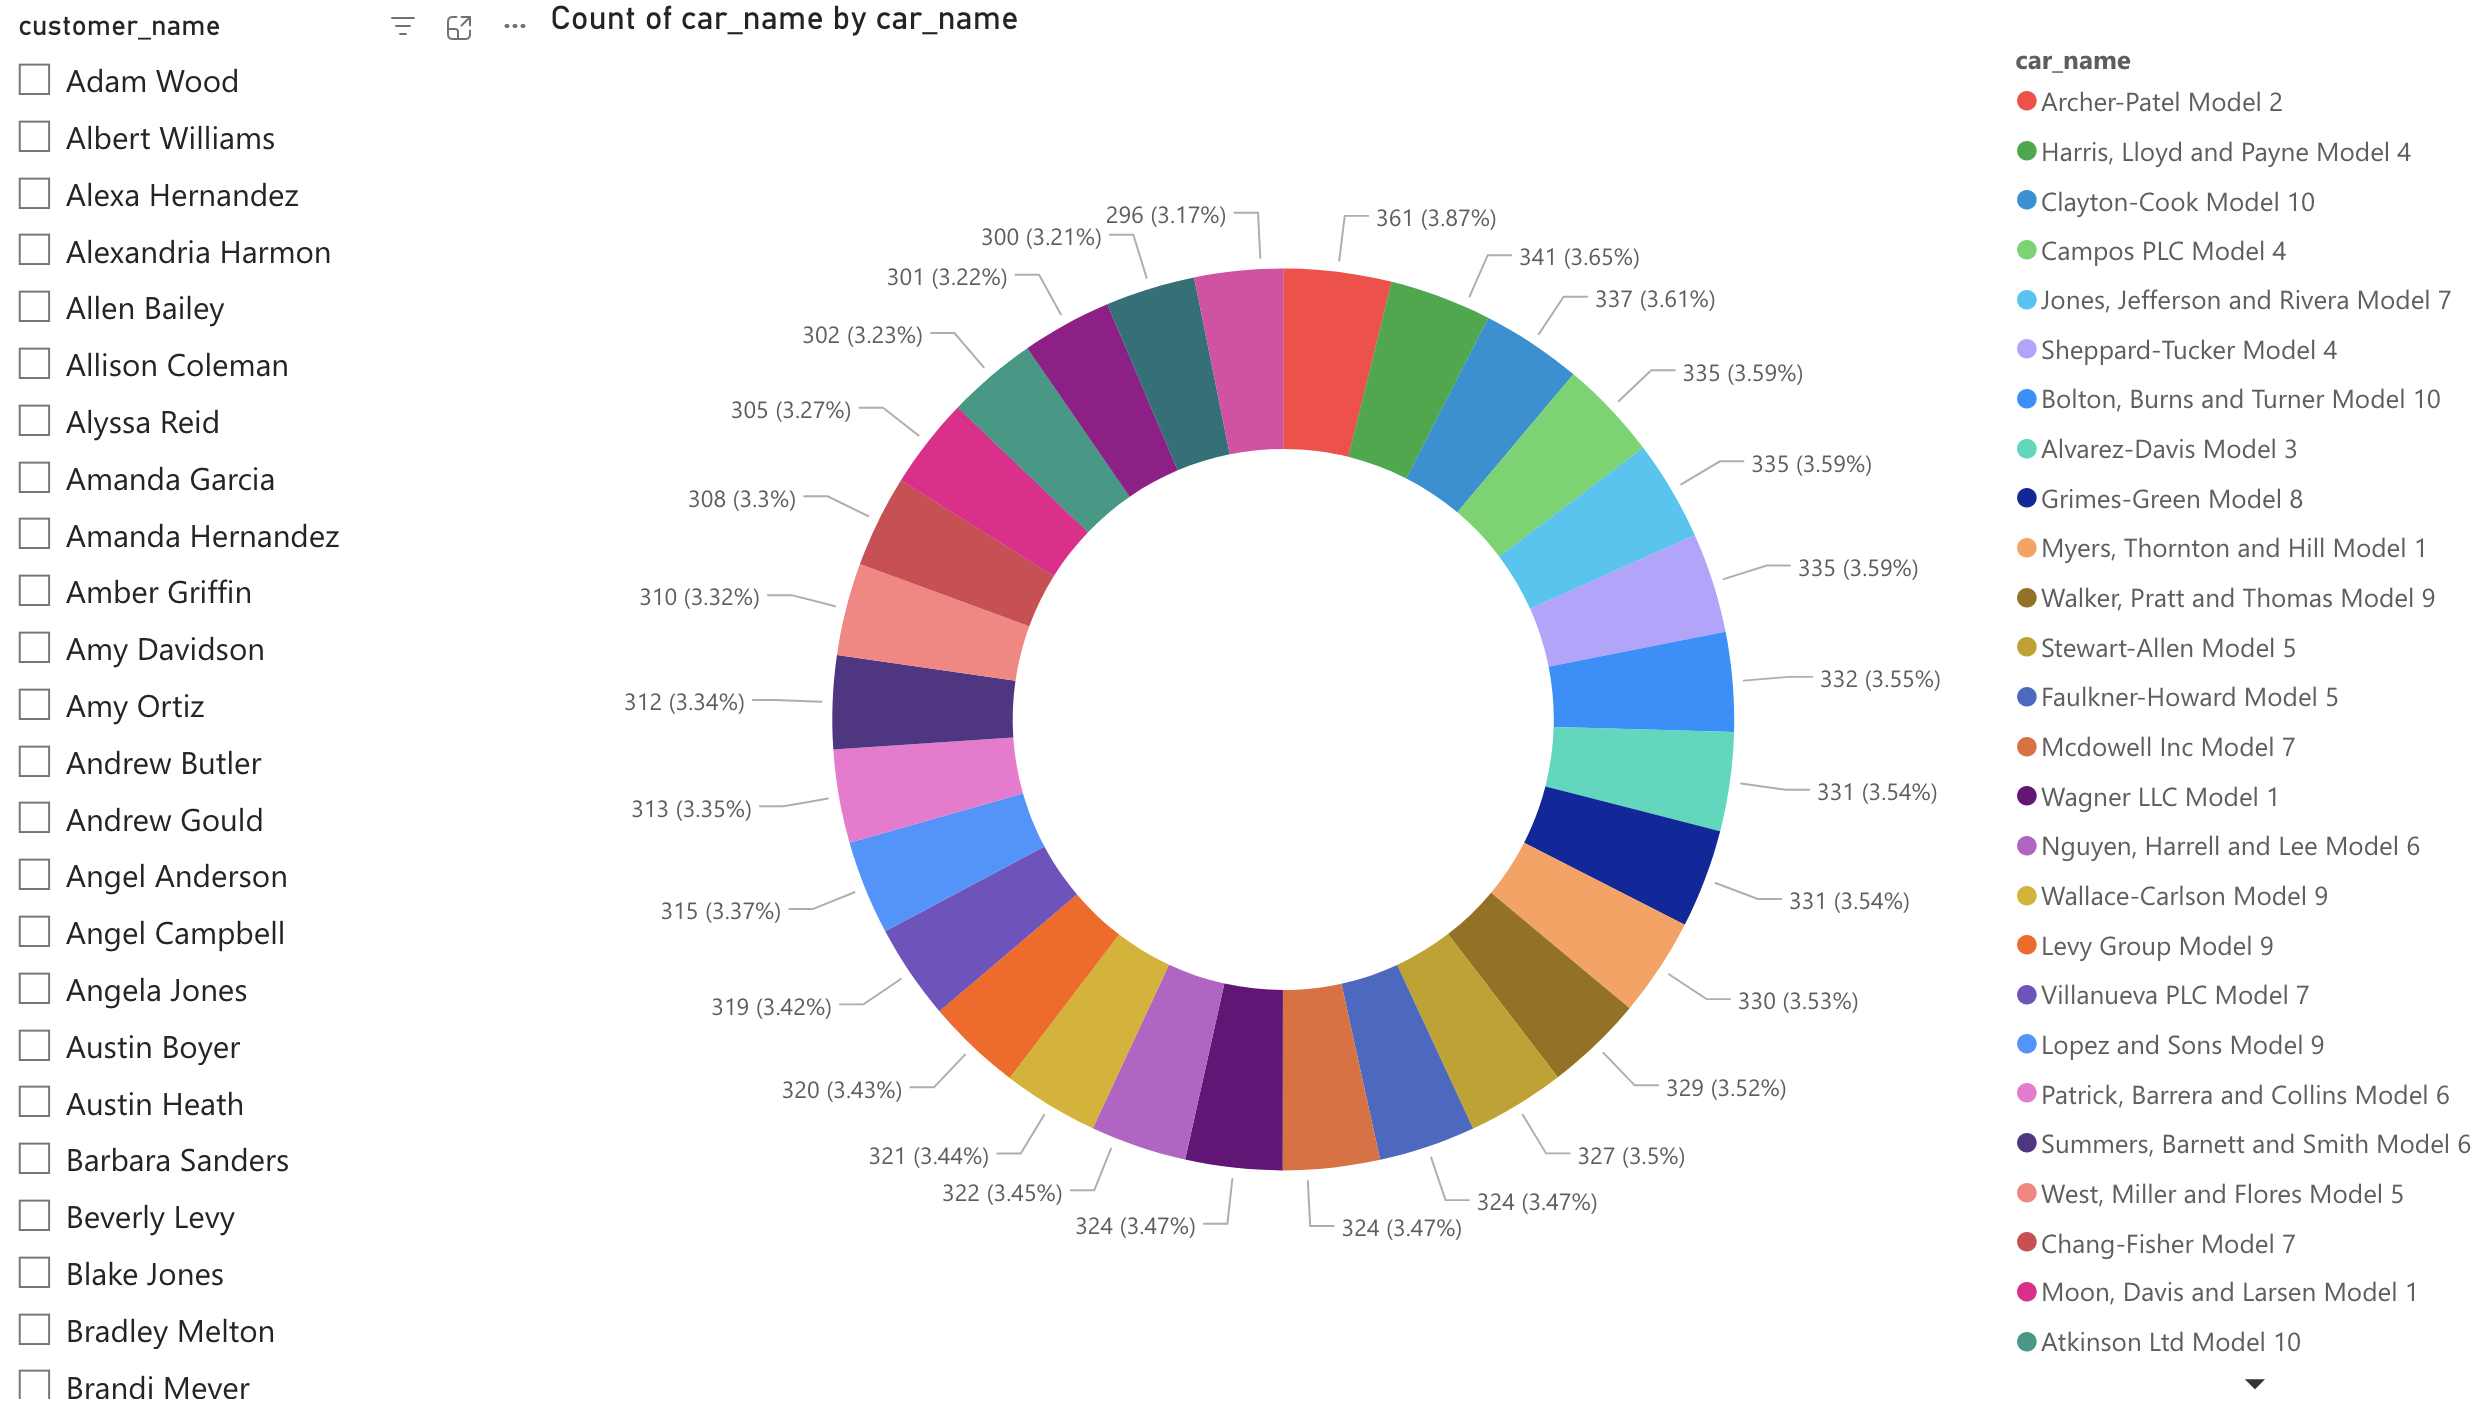

## Cars by Customers (Amy Ortiz)

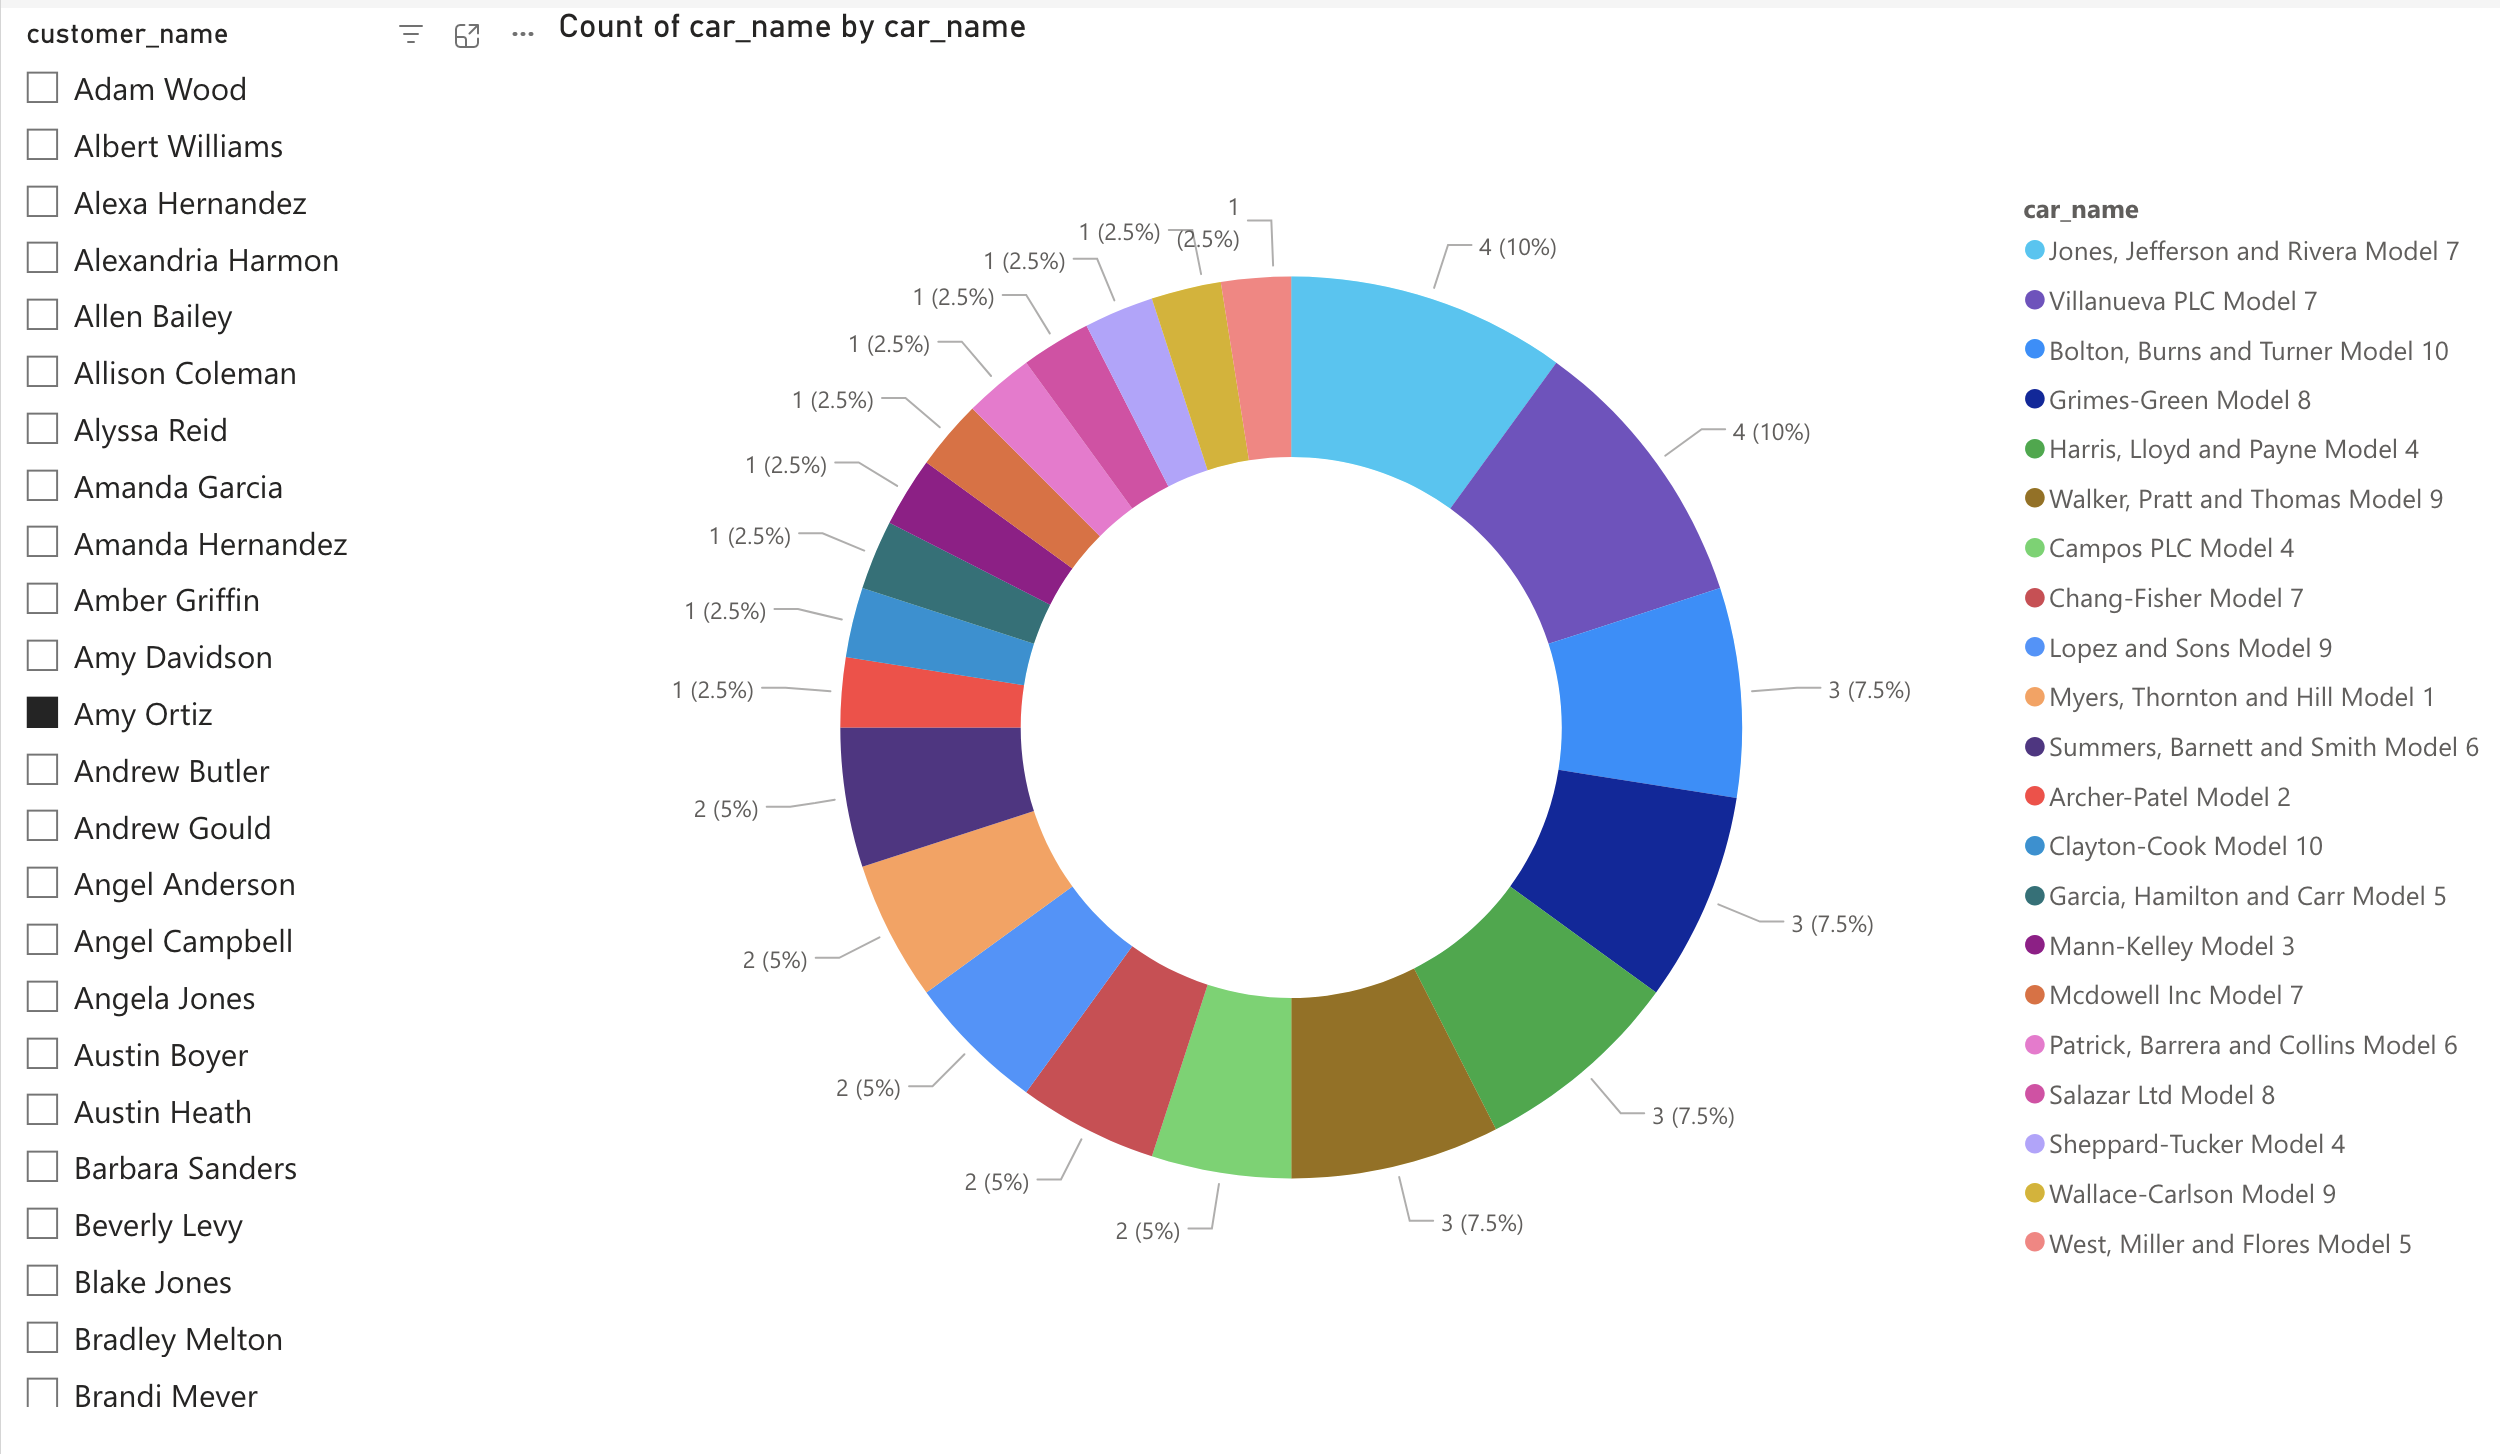